<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# History match the Freyberg model using a two parameters ``K`` and ``R`` using head and flux observations

#### Where are we on the Goldilocks complexity curve? 

<img src="Hunt1998_sweetspot.png" style="float: center">



The runs so far were intended to be greatly oversimplified so as to be a starting point for adding complexity. However, when we added just __*one more parameter*__ for a total of 2 parameters uncerainty for some forecasts got appreciably __worse__.  And these parameters cover the entire model domain, which is unrealistic for the natural world!  Are we past the "sweetspot" and should avoid any additional complexity even if our model looks nothing like reality?  

Adding parameters in and of itself is not the real problem.  Rather, it is adding parameters that influence forecasts but are unconstrained by observations so that they are free to wiggle and ripple uncertainty to our forcasts.  If observations are added that help constrain the parameters, the forecast observation will be more certain. That is, the natural flip side of adding parameters is constraining them, with data (first line of defense) or soft-knowledge and problem dimension reduciton (SVD).  

Anderson et al. (2015) suggest that at a minimum groundwater models be history matched to heads and fluxes.  There is a flux observation in our PEST control file, but it was given zero weight.  Let's see what happens if we move our model to the minimum calibration of Anderson et al.

#### Objectives for this notebook are to:

1) Add a flux observation to the measurement objective function of our Freyberg model

2) Explore the effect of adding the observation to history matching, parameter uncertainty, and forecast uncertainty

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.write(os.path.join(working_dir,pst_name))

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_k_and_r_fluxobs/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/03/30 15:39:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time ste

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


Util2d:hk layer 1: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:sy: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to external
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_k_and_r_fluxobs/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/03/30 15:39:47

 Solving:  Stress period:    

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


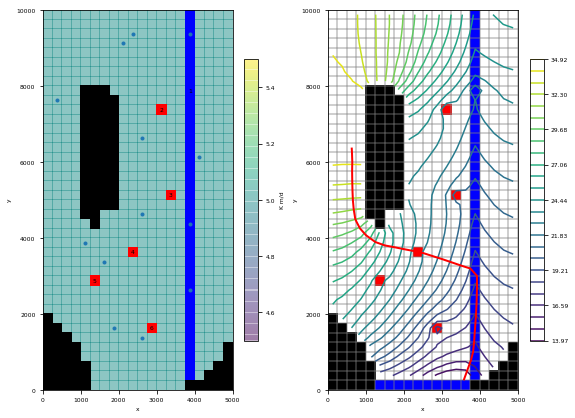

In [3]:
fs.plot_model(working_dir, pst_name)

In [ ]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

``PEST++`` only ran the model one time - because NOPTMAX=0, but that is what we want at this point to interrogate the model at initial values.  

### Let's look at all observations in the PEST run

In [ ]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.observation_data

Wow!  that's a lot of observations.  Why so many?  Answer:  we are "carrying" lots of model outputs that may be of interest to us later __(not just places and times where we have actual measurements)__.  These outputs include forecasts as well as *"potential" observation* locations we will use in dataworth analysis (more on that later)

But, the calibration only uses observations where you assign weights.  Let's get a listing of just those.

In [ ]:
pst.observation_data.loc[pst.nnz_obs_names,:]

Let's give the observation ``rivflux_cal`` a non-zero weight.  You can do this in a text editor but we'll do it in the next block and see the report out for convenience. We chose a new weight of 0.05 for this problem, but we'll spend more time on the concepts involved with observation weighting in a later notebook.

In [ ]:
obs = pst.observation_data
obs.loc[obs.obgnme=="calflux","weight"] = 0.05 #super subjective
pst.observation_data.loc[pst.nnz_obs_names,:]

### Now let's change NOPTMAX from 0 to 20 so we can see what the effect of weighting the flux target is

In [ ]:
pst.control_data.noptmax = 20
pst.write(os.path.join(working_dir,pst_name))

### And we'll run the model - look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [ ]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

Let's explore the results, how did we do with fit (lowering PHI)?

In [ ]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

## Egads!  Our Phi is a bit larger!  Are we moving backwards? Oh wait, we added a new weighted observation, so we can't compare it directly to what we had with only head observations.


#### Okay, what did it do to our parameter uncertainty?

In [ ]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

# Hold the phone - only K is showing here.  Did we run PESTCHEK before burning the silicon? 

 (Remember last notebook where we said:  "Let's run PESTCHEK and see what it says about our freyberg.pst file"?)

In [ ]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

#### Well the instructors gave you the same PEST control file as last exerisce!  Some one should tell them that it was "curious" in the last notebook but vexxing now, because we again see that in the PESTCHEK warning section it says "All parameters belonging to the parameter group "rch" are either fixed or tied". That is flagged as a warning because PESTCHEK is wondering (with good reason in this case) why would it not be adjustable after you went to all the trouble to define it as a parameter.  But, there  are times you may want to do this, so it is classified as a warning and isn't going to stop you.

#### But that is not what we want, we want to make recharge a parameter in this activity and redo our work (did we remember to mention the importance of running PESTCHEK?)

### Open the PEST control file freyberg.pst in your text editor.  

1) Look in the parameter data section

2) Find the parameter __rch_0__ (the recharge for the calibration period) and make it adjustable (hint:  look at the other parameters) 

3) Save the file

4) Run PESTCHEK on the PEST control file in a seperate terminal window or by executing the next code block and looking at the terminal window where you launched this notebook

## Or run this next pyemu block

In [ ]:
pst.parameter_data.loc["rch_0",'partrans'] = "log"
pst.write(os.path.join(working_dir,pst_name))

In [ ]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

### Now to redo our steps from above....look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [ ]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

### Again, let's look at results

In [ ]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

### not much improvement in phi from before,  what's the point?

In [ ]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

### Much better - thanks PESTCHEK.  Yes, RCH_0 has a mean of zero but remember we log transformed it and it is reported in log space.  

### Now let's compare the parameter uncertainty results with the flux observation above to the previous run where we zero weighted the flux observation below:

In [ ]:
df_paru_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                        working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru_base


###  Uncertainty is lower when we add an observation that can constrain the parameters.  

### Here's the parameter uncertainty for the K and R parameters, side by side, heads+flux observation vs heads only

In [ ]:
df_paru_concat = pd.concat([df_paru,df_paru_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_paru_concat

Interesting - a tradeoff with fit between the two types of observations...


###  Let's plot these up like before.  Here's the prior and posterior standard deviations (blue is with flux observation weighted, green is with zero weight on the flux target)


In [ ]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

##  Wow, from an uncertainty standpoint, the flux observation has helped us learn a lot about recharge, and the uncertainty in HK improved to (blue posterior is narrower and higher than green)

# let's look at our forecasts - here's the K and R model with the flux observation with weight:

In [ ]:
df_foreu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu.post_stdev / df_foreu.prior_stdev))

df_foreu

### Compare these results with the ``k_and_r`` model *without* the flux observation (below):

In [ ]:
df_foreu_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                         working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu_base.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu_base.post_stdev / df_foreu_base.prior_stdev))
df_foreu_base

### And here the forecast uncertianties are side by side

In [ ]:
df_foreu_concat = pd.concat([df_foreu,df_foreu_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_foreu_concat

### and plotted ( (blue is with flux observation weighted, green is with zero weight on the flux target)

In [ ]:
for forecast in pst.forecast_names:
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    pyemu.helpers.plot_summary_distributions(df_foreu.loc[[forecast.upper()],:],ax=ax1)
    pyemu.helpers.plot_summary_distributions(df_foreu_base.loc[[forecast.upper()],:],
                                             ax=ax2,pt_color='g')
    xlim1, xlim2 = ax1.get_xlim(),ax2.get_xlim()
    xmx = max(xlim1[1],xlim2[1])
    xmn = min(xlim1[0],xlim2[0])
    ax1.set_xlim(xmn,xmx)
    ax2.set_xlim(xmn,xmx)
    ylim1, ylim2 = ax1.get_ylim(),ax2.get_ylim()  
    ymx = max(ylim1[1],ylim2[1])
    ymn = min(ylim1[0],ylim2[0])
    ax1.set_ylim(ymn,ymx)
    ax2.set_ylim(ymn,ymx)
    
    
    ax1.set_title(forecast)
    ax2.set_title("without flux obs")
    plt.show()

In [ ]:
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()

# Advanced digression - what's wrong with FOSM...
### Why are the Prior distributions for the flux obs and no flux obs forecasts different? - I thought Priors should be the same between these two?

In [ ]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

df = jco.to_dataframe()

df.loc["travel_time",:]

In [ ]:
jco = pyemu.Jco.from_binary(os.path.join("..","freyberg_k_and_r",working_dir,pst_name.replace(".pst",".jcb")))

df2 = jco.to_dataframe()
df2.loc["travel_time",:]

### well the parameter sensitivity is different at these different optimal values.... 

### The information in the flux obs has reduced river flux forecast uncertainty dramatically, but has not really improved what we had before with respect to the ``travel_time`` or head forecasts.  So on first blush we see that the same model/observation data set can make some forecasts better but not others

### But there is more to it than that - think about which observation helped which parameter and which forecast the most.  Is there an "birds of the feather" type of thing going on?  


# Okay, we took you a long way but doesn't our approach to uncertainty have a huge flaw?  We freed recharge rch_0 which is the calibration period that we know something about.  But we left the recharge in the forecast period (rch_1) fixed - which is saying that we know it perfectly, which makes no sense.  This set of blocks will recreate the steps above and get us back to the parameter and forecast uncertainty plots....

In [ ]:
pst.parameter_data.loc[["rch_0","rch_1"],"partrans"] = "log"
pst.write(os.path.join(working_dir,pst_name))
pst.parameter_data



In [ ]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

In [ ]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

In [ ]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

In [ ]:
df_paru_f = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru_f

In [ ]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru_f,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    if pname.upper() == "RCH_1":
        continue
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

# Ah, for the future recharge there is not change between the prior and posterior uncertainty, but this makes sense because there are no weighted observations (information) regarding the future. So our calibration data tells us nothing about the this parameter.  

## How does this new source of uncertainty ripple to our forecast uncertainty?

# Jeremy - can you fix this so it plots the rch_1 fixed vs freed change in FOSM?

In [ ]:
df_foreu_f = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu_f

In [ ]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_foreu_f,subplots=True)
for forecast,ax in zip(pst.forecast_names,axes):
    pyemu.helpers.plot_summary_distributions(df_foreu.loc[[forecast.upper()],:],ax=ax,pt_color="g")

In [ ]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
df = jco.to_dataframe()

In [ ]:
df.loc[pst.forecast_names,:]

In [ ]:
df_foreu_concat = pd.concat([df_foreu,df_foreu_f],join="outer",axis=1,keys=["base","rch_1"])
df_foreu_concat

In [ ]:
df_foreu_concat.sort_index(axis=1,inplace=True)
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()

### We see that the posterior for most forecasts is increased because of including future recharge uncertainty.  Intutitively, it makes sense because future recharge directly influences water levels and fluxes in the future.  And since calibration (history-matching) can't tell us anything about future recharge.  This means there is no data we can collect to reduce this source of uncertainty....